In [1]:
import numpy as np
import pandas as pd
import scipy.signal
from scipy.stats import logistic
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.integrate import simpson
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from fdasrsf.regression import elastic_regression
from fdasrsf.utility_functions import elastic_distance
import fdasrsf as fs
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [2]:
# ys = np.load('/mnt/sdb/arafat/U-Extend/paper_data/all_knock.npy')[:,:,1]
# pids = np.loadtxt('/mnt/sdb/arafat/U-Extend/paper_data/pids_knock.txt')
# visits = np.loadtxt('/mnt/sdb/arafat/U-Extend/paper_data/visits_knock.txt', dtype=str)

ys = np.loadtxt('ys_knock_wodelta.txt')
pids = np.loadtxt('pids_knock_wodelta.txt')
visits = np.loadtxt('visits_knock_wodelta.txt', dtype=str)

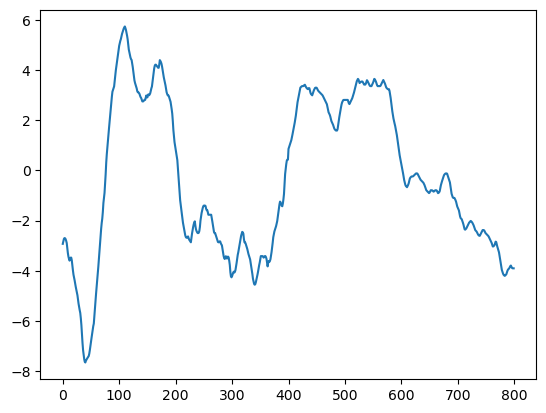

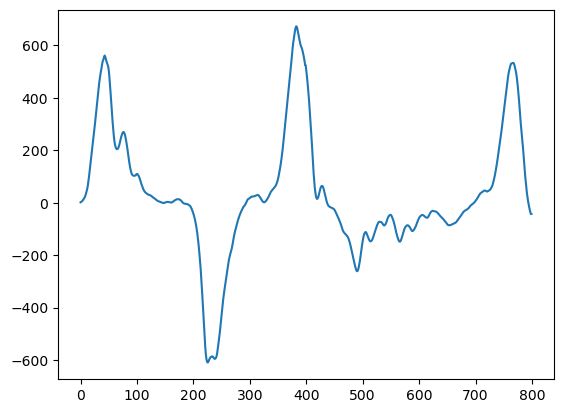

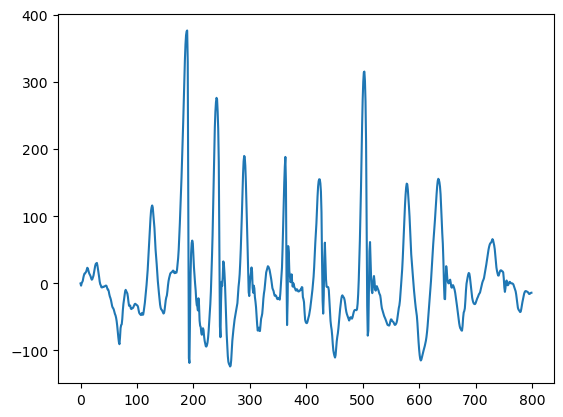

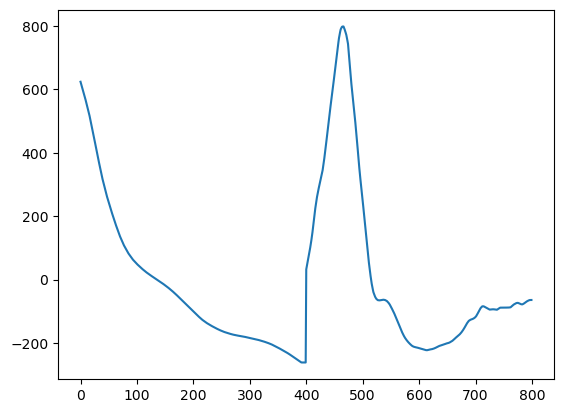

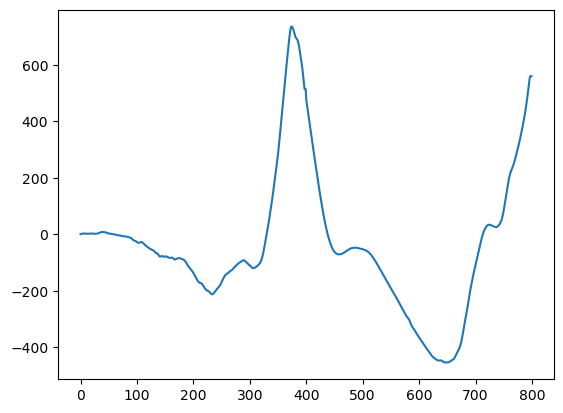

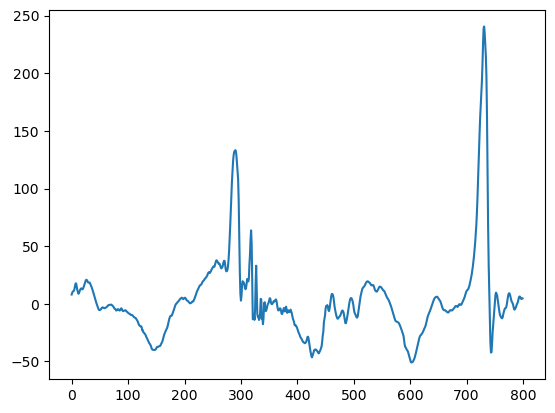

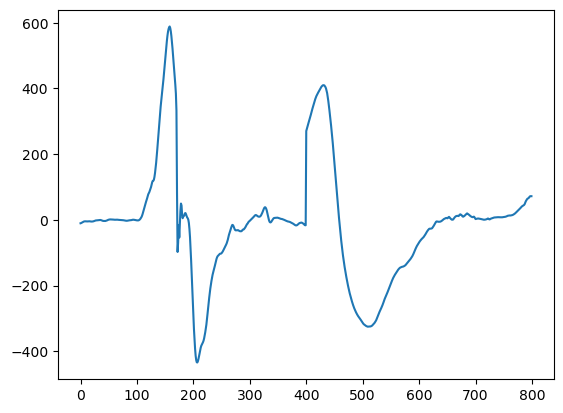

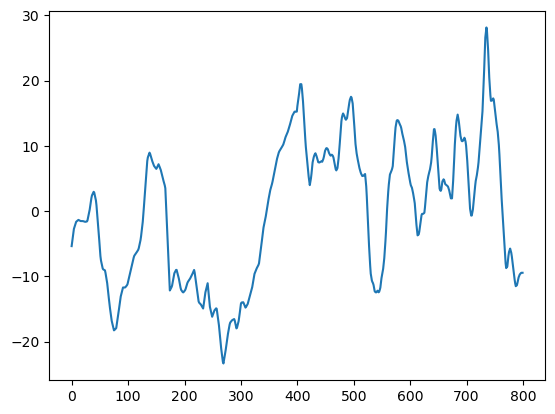

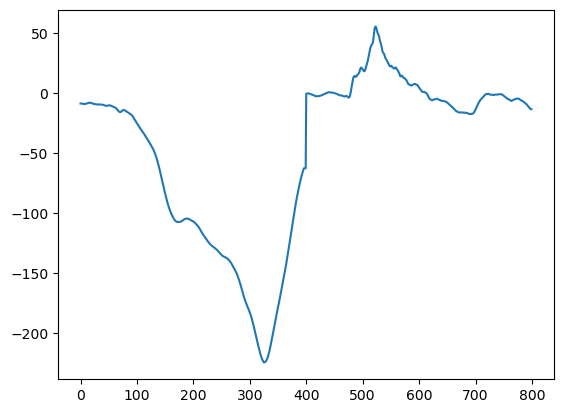

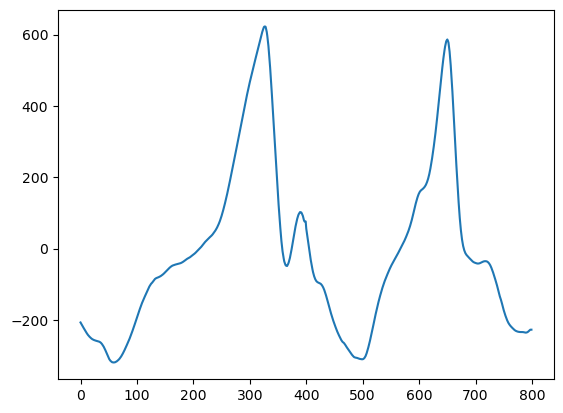

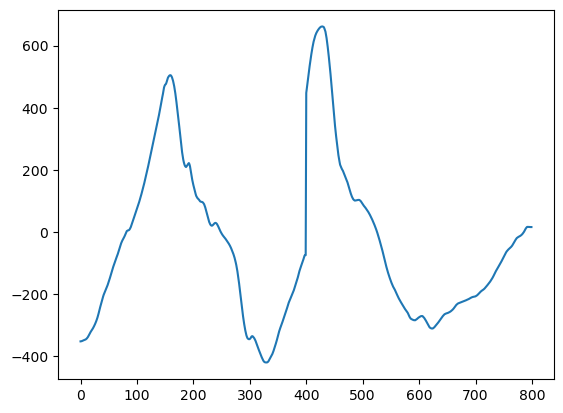

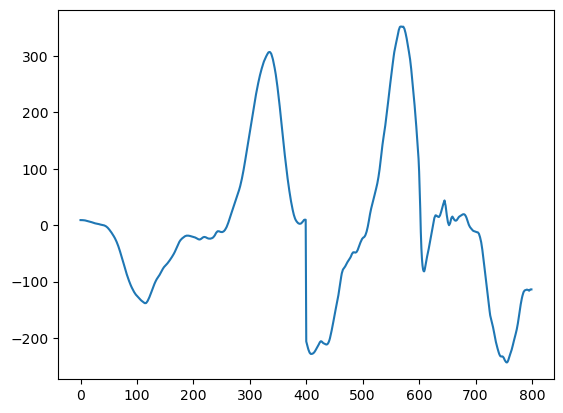

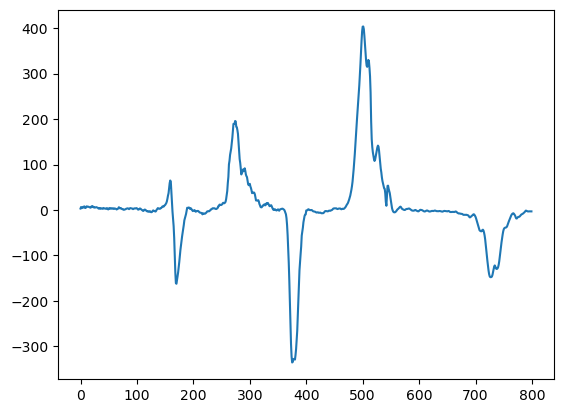

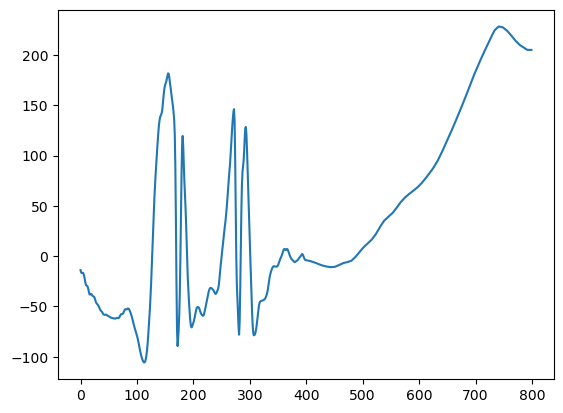

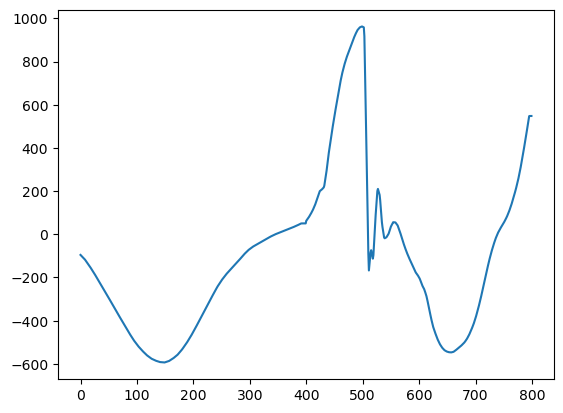

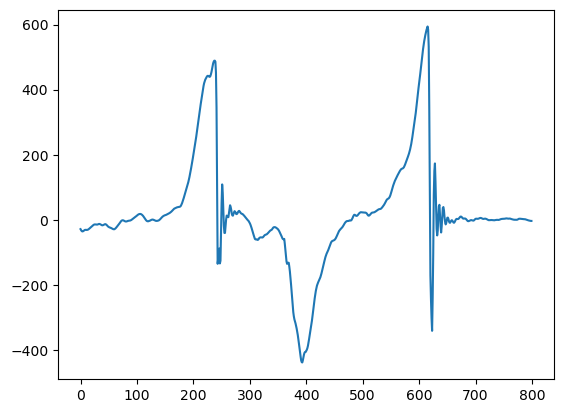

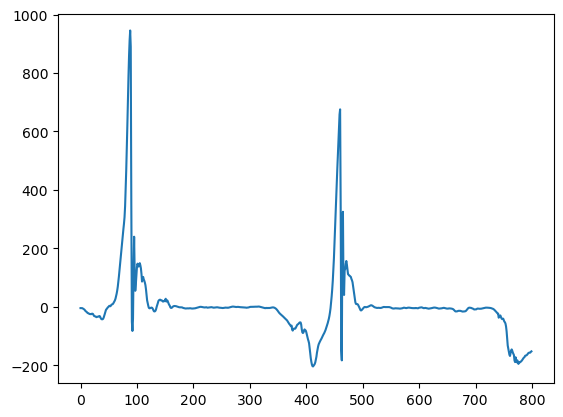

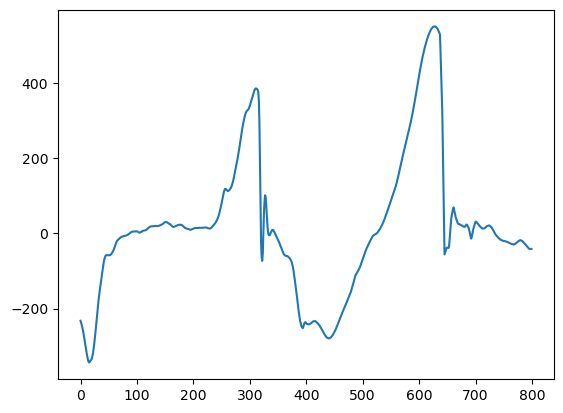

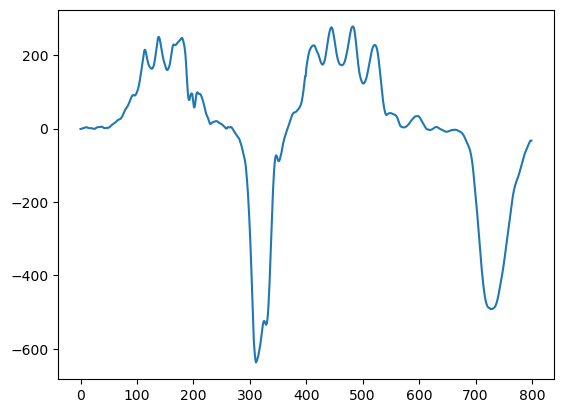

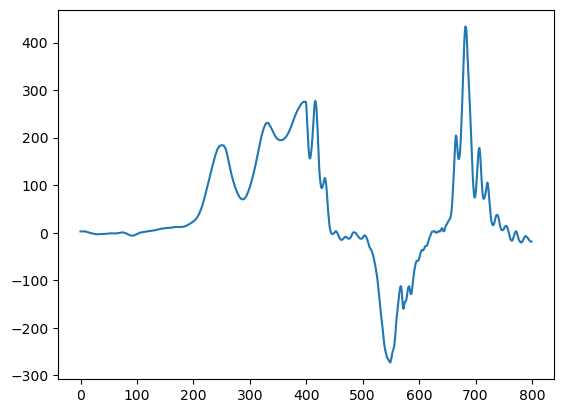

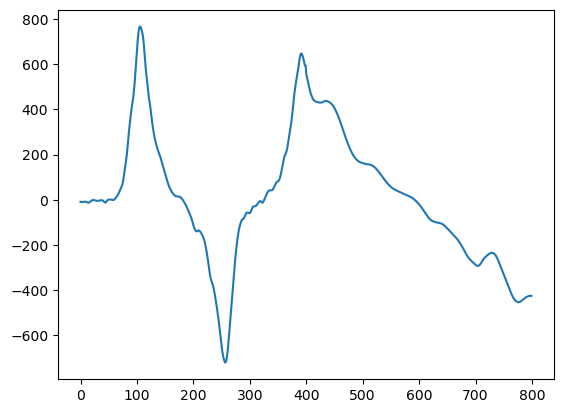

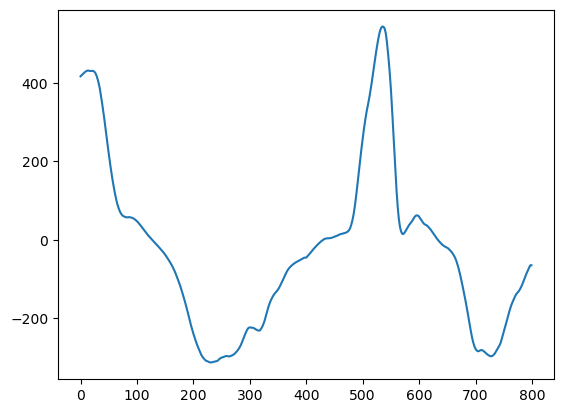

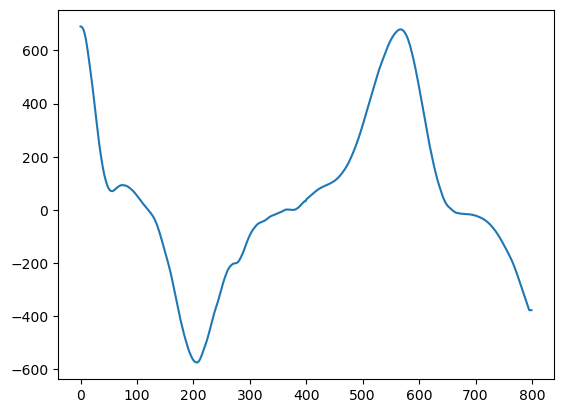

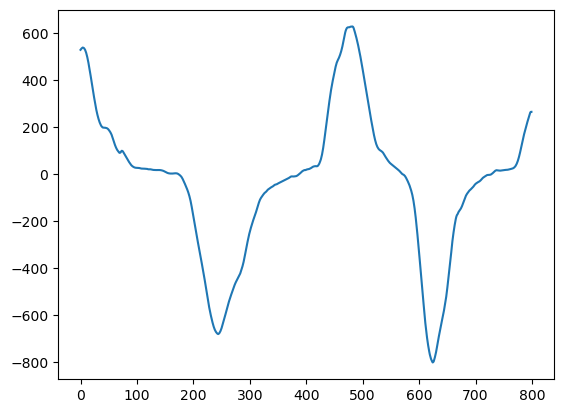

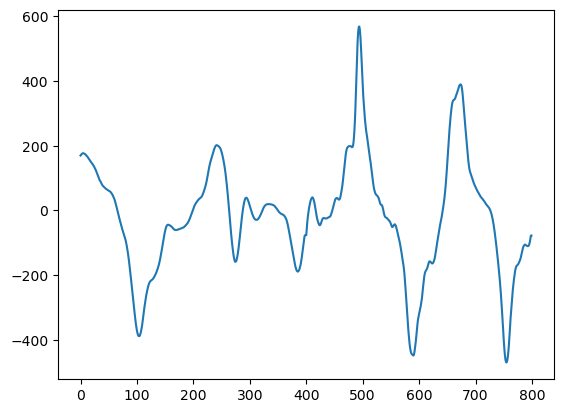

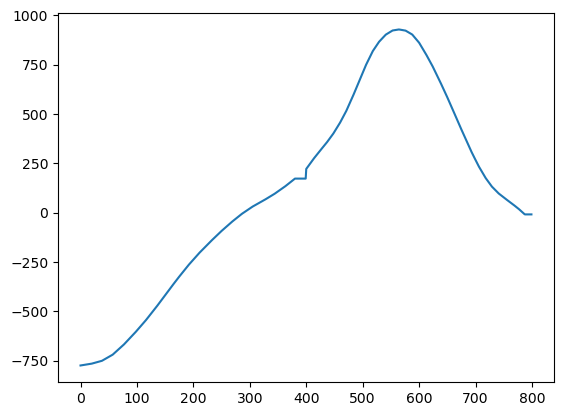

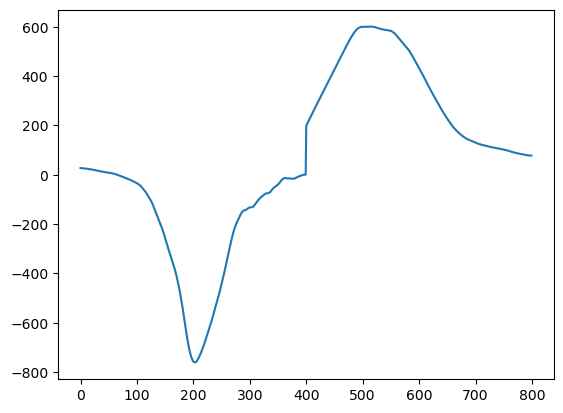

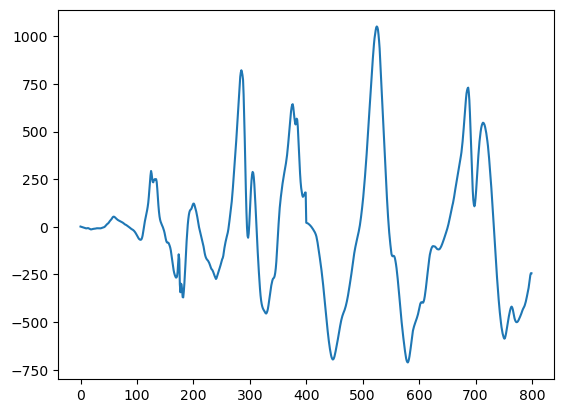

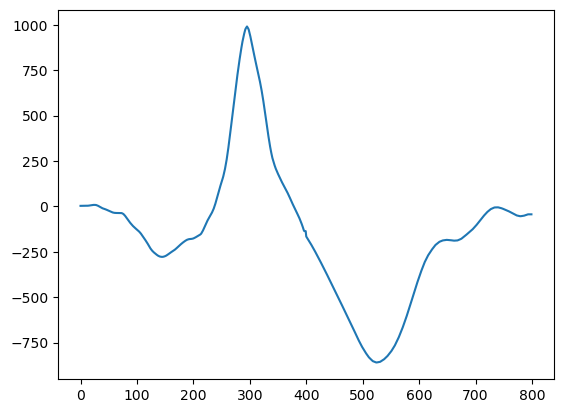

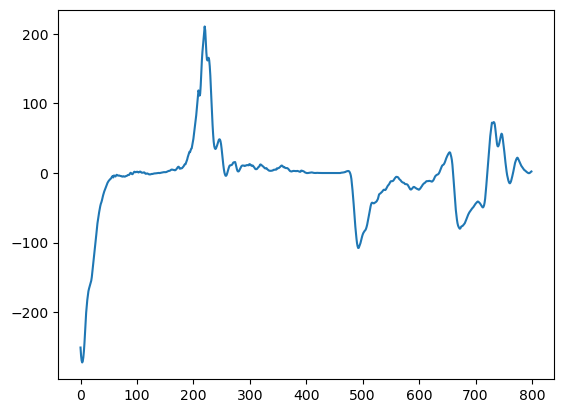

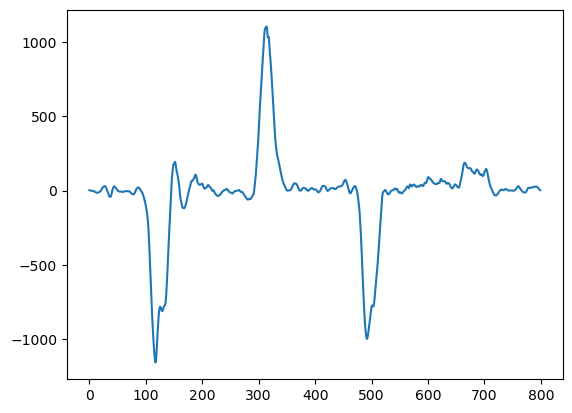

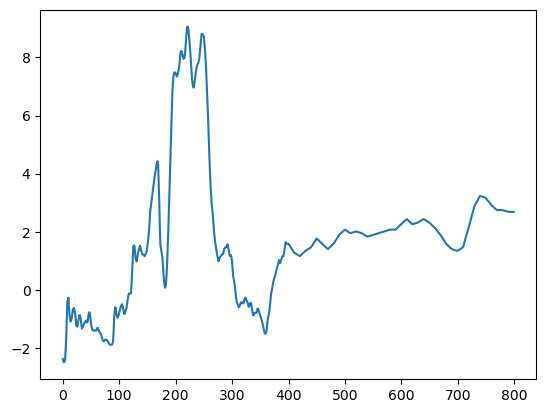

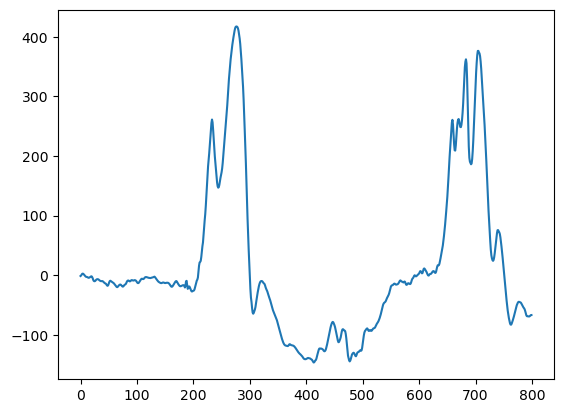

In [3]:
newys = []
newpids = []
newvisits = []

for i in range(0, len(ys), 2):
    ysarray = np.array(ys)
    newys.append(np.concatenate((ysarray[i, :], ysarray[i+1, :])))
    newpids.append(pids[i])
    newvisits.append(visits[i])

for i in range(len(newys)):
    plt.figure()
    plt.plot(newys[i])

In [4]:
ys = newys
pids = newpids
visits = newvisits

df_processor = pd.DataFrame(ys)
df_processor['pids']=pids
df_processor['visits']=visits

baseline_df = pd.read_csv('/mnt/sdb/arafat/U-Extend/paper_data/final_clinical_df.csv')
baseline_df = baseline_df.drop(columns=['Dom','Gender'])

baseline_df['Normalized_Dynamometry (N/cm)'] = baseline_df['Avg. Dynamometry (N)'] / baseline_df['Forearm_Length (cm)']
baseline_df['Normalized Elbow Torque (Nm/cm)'] = baseline_df['Elbow Torque (Nm)'] / baseline_df['Forearm_Length (cm)']

df_processor['visits'] = pd.to_datetime(df_processor['visits'])
df_processor['visits'] = df_processor['visits'].apply(lambda x: x.strftime('%Y-%m-%d'))
df_processor['visits'] = pd.to_datetime(df_processor['visits'], format = "%Y-%m-%d")

baseline_df['Sensor Data Date'] = pd.to_datetime(baseline_df['Sensor Data Date'], format = "%Y-%m-%d")
df_processor = pd.merge(df_processor, baseline_df, left_on=['pids','visits'], right_on=['PID','Sensor Data Date'], how='inner')

In [5]:
def random_sample(group):
    return group.sample(n=1)

In [6]:
random_rows = df_processor.groupby(['pids']).apply(random_sample).reset_index(drop=True)
ys = random_rows.iloc[:,0:800].values
ys.shape

(29, 800)

In [7]:
ys_scaled = (ys - ys.min()) / (ys.max() - ys.min())

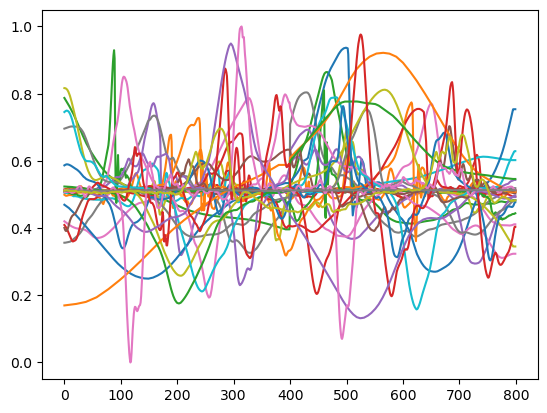

In [8]:
plt.figure()
for i in range(len(ys_scaled)):
    plt.plot(ys_scaled[i,:])
    #plt.plot(ys[i,:])
    #plt.show()

In [9]:
from sklearn.decomposition import NMF

R = ys_scaled

R = np.array(R)
nmf = NMF(n_components = 3)
W = nmf.fit_transform(R);
H = nmf.components_;
nR = np.dot(W,H)

print(W.shape, H.shape)

(29, 3) (3, 800)


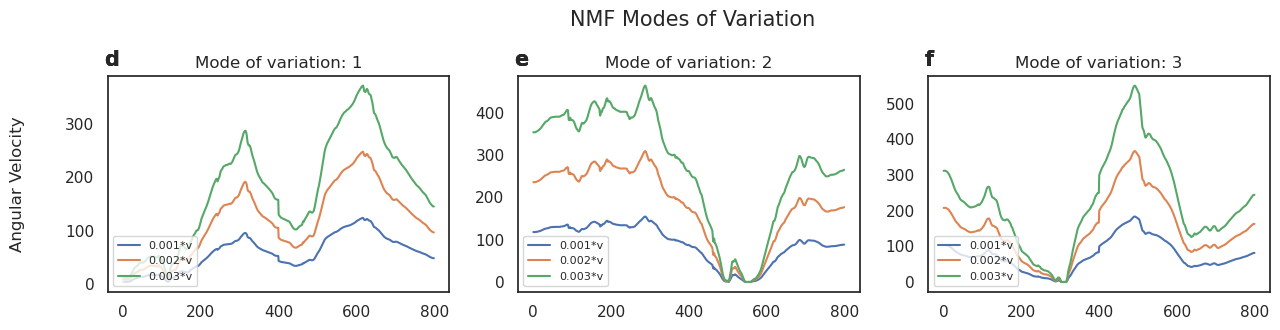

In [10]:
sns.set(font_scale=1)
sns.set(style='white')
# sns.color_palette("tab10")

fig, axs = plt.subplots(1, 3, figsize=(15, 3))
labels = ['d', 'e', 'f']

for i, ax in enumerate(axs):
    ax.set_title('Mode of variation: {}'.format(i+1), fontsize=12)
    for j in [0.001, 0.002, 0.003]:
        ax.plot(j*H[i,:]*200000, label="{}*v".format(j))
        ax.text(-0.01, 1.12, labels[i], transform=ax.transAxes, fontsize=15, 
                verticalalignment='top', fontweight='bold')
        ax.legend(loc='lower left', fontsize=8)
    
plt.subplots_adjust(top=0.83)
plt.suptitle('NMF Modes of Variation', fontsize=15, y=1.05, x=0.515)
fig.text(0.06, 0.47, 'Angular Velocity', va='center', rotation='vertical', fontsize=12)
plt.savefig('pics/NMF_eigenfunctions.png', dpi=300, bbox_inches='tight')

In [11]:
# newdf = pd.DataFrame(W)
# newdf.columns = ['vpc1_curl', 'vpc2_curl','vpc3_curl']
# newdf = pd.concat([df_processor, newdf], axis =1)
# newdf

In [12]:
# newdf = newdf.groupby(['PID']).agg({'Age':'mean',
#                                     'Forearm_Length (cm)':'mean',
#                                     'CSA (cm^2)':'mean',
#                                     'Avg_Echo':'mean',
#                                     'Normalized Elbow Torque (Nm/cm)':'mean',
#                                     'vpc1_curl':'mean',
#                                     'vpc2_curl':'mean',
#                                     'vpc3_curl':'mean',
#                                     'Brooke':'mean',
#                                     'Cohort':'first',
#                                     'PID':'first'})

In [13]:
# newdf

In [14]:
# newdf.to_csv('curl_vpc_NMF.csv', index=False)

In [15]:
# print(W.shape)

In [16]:
# print(H.shape)

## NMF Multi

In [17]:
from sklearn.decomposition import NMF
from tqdm.notebook import tqdm

nmfs = []

trials = 100

for trial in tqdm(range(trials)):

    # Then apply the function to each group defined by 'pid' and the sampled 'visit' to randomly sample based on 'trial'
    random_rows = df_processor.groupby(['pids']).apply(random_sample).reset_index(drop=True)
    ys = random_rows.iloc[:,0:800].values
    ys_scaled = (ys - ys.min()) / (ys.max() - ys.min())

    R = ys_scaled

    R = np.array(R)
    nmf = NMF(n_components = 3)
    W = nmf.fit_transform(R);
    H = nmf.components_;
    nR = np.dot(W,H)

    newdf = pd.DataFrame(W)
    newdf.columns = ['vpc1_knock', 'vpc2_knock','vpc3_knock']
    newdf = pd.concat([random_rows.iloc[:,800:], newdf], axis =1)
    nmfs.append(newdf)

  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
# Separate numeric and non-numeric data
numeric_dfs = [df.select_dtypes(include='number') for df in nmfs]
non_numeric_df = nmfs[0].select_dtypes(exclude='number')

# Calculate the mean of numeric data
numeric_mean_df = sum(numeric_dfs) / len(numeric_dfs)

# Combine numeric mean with non-numeric data from the first DataFrame
mean_df = numeric_mean_df.join(non_numeric_df)
mean_df.to_csv('nmf_multi_knock.csv',index=False)